# Deep Learning

## Assignment 1

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.
This notebook uses the notMNIST dataset to be used with python experiments. This dataset is designed to look like the classic MNIST dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


## Problem 1

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

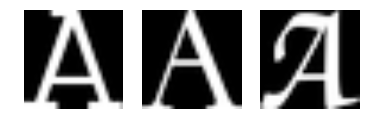

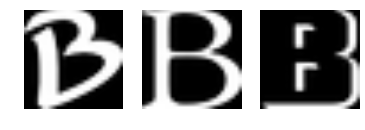

In [4]:
from PIL import Image
from matplotlib.pyplot import imshow,figure,axis
import random
import glob

m = 2 #pick number of letter classes to be displayed (1 to 10)
n = 3 #pick number of samples to be taken
for i in np.arange(m):
    files = glob.glob(train_folders[i]+ '/*.png')
# files = glob.glob(path.replace("letter",ltr))
    ranFile = random.sample(files,n)
    fig = figure() 
    for file in np.arange(n):
        a=fig.add_subplot(1,n,file+1)
        im = Image.open(ranFile[file])
        imshow(im,cmap='Greys_r')
        plt.axis('off') 

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.

A few images might not be readable, we'll just skip them.

In [5]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

./notMNIST_large/A.pickle already present - Skipping pickling.
./notMNIST_large/B.pickle already present - Skipping pickling.
./notMNIST_large/C.pickle already present - Skipping pickling.
./notMNIST_large/D.pickle already present - Skipping pickling.
./notMNIST_large/E.pickle already present - Skipping pickling.
./notMNIST_large/F.pickle already present - Skipping pickling.
./notMNIST_large/G.pickle already present - Skipping pickling.
./notMNIST_large/H.pickle already present - Skipping pickling.
./notMNIST_large/I.pickle already present - Skipping pickling.
./notMNIST_large/J.pickle already present - Skipping pickling.
./notMNIST_small/A.pickle already present - Skipping pickling.
./notMNIST_small/B.pickle already present - Skipping pickling.
./notMNIST_small/C.pickle already present - Skipping pickling.
./notMNIST_small/D.pickle already present - Skipping pickling.
./notMNIST_small/E.pickle already present - Skipping pickling.
./notMNIST_small/F.pickle already present - Skipping pi

## Problem 2

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

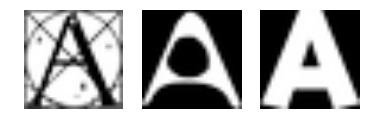

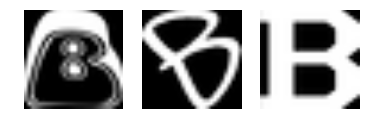

In [21]:
import pickle
m = 2 #number of letter classes (1 to 10)
n = 3 #number of samples
for i in np.arange(m):
    f = open(train_datasets[i], 'r')
    letterSet = pickle.load(f) 
    f.close
    d = letterSet.shape[0]
    ranIndex = random.sample(np.arange(d),n)
    fig = figure() 
    for j in np.arange(n):
        a=fig.add_subplot(1,n,j+1)
        imshow(letterSet[ranIndex[j]],cmap='Greys_r')
        plt.axis('off') 


## Problem 3

Another check: we expect the data to be balanced across classes. Verify that.

In [7]:
#we count the number of images in each letter class
letters = 'ABCDEFGHIJ'
for i in np.arange(10):
    f = open(train_datasets[i], 'r')
    letterSet = pickle.load(f) 
    f.close
    print ('Size of the train data set for class "' + letters[i] + '" is: ' + str(len(letterSet)))

Size of the train data set for class "A" is: 52909
Size of the train data set for class "B" is: 52911
Size of the train data set for class "C" is: 52912
Size of the train data set for class "D" is: 52911
Size of the train data set for class "E" is: 52912
Size of the train data set for class "F" is: 52912
Size of the train data set for class "G" is: 52912
Size of the train data set for class "H" is: 52912
Size of the train data set for class "I" is: 52912
Size of the train data set for class "J" is: 52911


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [8]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [9]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

## Problem 4

Convince yourself that the data is still good after shuffling!


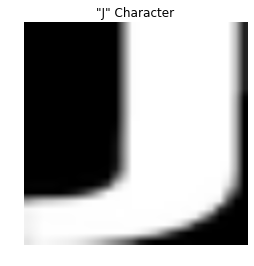

In [22]:
def check_data(dataset,labels):
    randSample = random.choice(np.arange(dataset.shape[0]))
    imshow(dataset[randSample],cmap='Greys_r')
    labelIx = labels[randSample]
    plt.title('"' + letters[labelIx] + '" Character')
    plt.axis('off'); 

check_data(train_dataset,train_labels)
    

Finally, let's save the data for later reuse:

In [11]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [12]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800514


## Problem 5

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it. Measure how much overlap there is between training, validation and test samples.
Optional questions:

What about near duplicates between datasets? (images that are almost identical)
Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.

In [13]:
#use hashing algorithms to detect overlap 
import hashlib 
def Hash(image):
    return hashlib.md5(image).hexdigest()

set_train_dataset = set([Hash(x) for x in train_dataset])
set_valid_dataset = set([Hash(x) for x in valid_dataset])
set_test_dataset = set([Hash(x) for x in test_dataset])

overlap_test_valid = set_test_dataset & set_valid_dataset
print('test-valid overlap: ' + str(len(overlap_test_valid)))

overlap_train_valid = set_train_dataset & set_valid_dataset
print ('train-valid overlap: ' + str(len(overlap_train_valid)))

overlap_train_test = set_train_dataset & set_test_dataset
print ('train-test overlap: ' + str(len(overlap_train_test)))

test-valid overlap: 55
train-valid overlap: 953
train-test overlap: 1153


In [14]:
#we can measure the number of duplicates in each dataset
duplicate_train = train_dataset.shape[0] - len(set_train_dataset) 
print('duplicate in train dataset: ' + str(duplicate_train))

duplicate_valid = valid_dataset.shape[0] - len(set_valid_dataset) 
print('duplicate in validation dataset: ' + str(duplicate_valid))

duplicate_test = test_dataset.shape[0] - len(set_test_dataset) 
print('duplicate in test dataset: ' + str(duplicate_test))

duplicate in train dataset: 12783
duplicate in validation dataset: 128
duplicate in test dataset: 220


what about near duplicates? I have used an algorithm called dhash from this [blog](http://blog.iconfinder.com/detecting-duplicate-images-using-python/). I had to apply a minor change and removed the gray scale conversion because we have already normalized our data.

In [15]:
import time

def dhash(image, hash_size=8):
    #grayscale and shrink the image in one step
#    image = image.convert('L').resize(
    image = image.resize(
            (hash_size+1, hash_size),Image.ANTIALIAS)
    pixels = list(image.getdata())
    #compare adjacent pixels
    difference = []
    for row in xrange(hash_size):
        for col in xrange(hash_size):
            pixel_left = image.getpixel((col,row))
            pixel_right = image.getpixel((col+1,row))
            difference.append(pixel_left > pixel_right)
            
    #convert the binary array to hexadecimal string
    decimal_value = 0
    hex_string = []
    for index, value in enumerate (difference):
        if value:
            decimal_value += 2**(index % 8)
        if (index % 8 == 7):
            hex_string.append(hex(decimal_value)[2:].rjust(2,'0'))
            decimal_value = 0
            
    return ''.join(hex_string)


def hamming_distance(s1, s2):
    """Return the Hamming distance between equal-length sequences"""
    if len(s1) != len(s2):
        raise ValueError("Undefined for sequences of unequal length")
    return sum(el1 != el2 for el1, el2 in zip(s1, s2))

# im1 = Image.fromarray(test_dataset[273])
# m1 = dhash(im1)
# im2 = Image.fromarray(valid_dataset[282])
# m2 = dhash(im2)
# m1,m2
# hamming_distance(m1, m2)

This task is very time-consuming. This is just to show how it works.

In [16]:
# train_dhash = [dhash(Image.fromarray(x)) for x in train_dataset]
# test_dhash = [dhash(Image.fromarray(x)) for x in test_dataset]
# valid_dhash = [dhash(Image.fromarray(x)) for x in valid_dataset]

# start_time = time.time()
# nearDup_test_valid = []
# # for i in xrange(len(test_dhash)):
# #     for j in xrange(len(valid_dhash)):
# for i in xrange(500):
#     for j in xrange(500):
#         m1 = test_dhash[i]
#         m2 = valid_dhash[j]
#         hd = hamming_distance(m1, m2)
#         if hd < 2: #this threshold should be optimized
#             temp = [i,j,hd]
#             nearDup_test_valid.append(temp) 
            
# print("--- %s seconds ---" % (time.time() - start_time))

# print(len(nearDup_test_valid))
# # nearDup_test_valid[240]


The next step wuld be creating a clean dataset for train, validation, and testing. We merge all datasets, remove the duplicates, shuffle data, split to train/validation/test. It should be noted that the following code does not consider near duplicated samples

size of labels = 220000
size of data = 220000
size of image files after cleaning = 204726


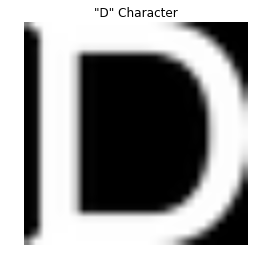

In [17]:
#merge all data
all_data = np.concatenate([train_dataset, valid_dataset, test_dataset])
all_labels = np.concatenate([train_labels, valid_labels, test_labels])

#check size of data                           
print('size of labels = ' + str(len(all_labels))) 
print ("size of data = " + str(all_data.shape[0]))

#we go through all_data and remove duplicates by keeping the unique values.
clean_data = []; clean_labels = []
hashDictionary = set() #create a dictionary of hash files to be checked for uniqueness.

for i in range(0,len(all_labels)):
    if not Hash(all_data[i]) in hashDictionary:
        clean_data.append(all_data[i])
        clean_labels.append(all_labels[i])
        hashDictionary.add(Hash(all_data[i]))
        
print('size of image files after cleaning = ' + str(len(clean_labels))) 

#convert list to dimensional array
clean_data = np.stack(clean_data)
clean_labels = np.stack(clean_labels)

#random permutation
clean_data, clean_labels = randomize(clean_data,clean_labels)

#check data validity
check_data(clean_data,clean_labels)

#split all_data to train, validation, and test datasets 
valid_dataset = clean_data[:10000]; valid_labels = clean_labels[:10000]
test_dataset =  clean_data[10000:20000]; test_labels = clean_labels[10000:20000]
train_dataset = clean_data[20000:]; train_labels = clean_labels[20000:]

#saving data structure
pickle_file = os.path.join(data_root, 'notMNIST_clean.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise


## Problem 6

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

In [23]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.cross_validation import cross_val_score

#we select logistic regression model as suggested
logregCV = LogisticRegressionCV()

def LogRegModel (dataset, labels, sample_size):
    Flat = [x.flatten() for x in dataset[:sample_size]] #flatten the image matrices
    Model = logregCV.fit(Flat, labels[:sample_size])
    Predict =  Model.predict(Flat)
    Score = cross_val_score(Model, Flat, labels[:sample_size]).mean()
    return Score

#cross validation error on clean dataset
score_50 = LogRegModel(train_dataset, train_labels, 50)
score_100 = LogRegModel(train_dataset, train_labels, 100)
score_1000 = LogRegModel(train_dataset, train_labels, 1000)
score_5000 = LogRegModel(train_dataset, train_labels, 5000)

print('cross validation error for train sample size of 50 : ' + str(score_50))
print('cross validation error for train sample size of 100 : ' + str(score_100))
print('cross validation error for train sample size of 1000 : ' + str(score_1000))
print('cross validation error for train sample size of 5000 : ' + str(score_5000))


cross validation error for train sample size of 50 : 0.406629318394
cross validation error for train sample size of 100 : 0.593150610288
cross validation error for train sample size of 1000 : 0.760018007904
cross validation error for train sample size of 5000 : 0.796004686123


In [19]:
#we can load original datasets and run our model on them. This helps us to evaluate the effect of data cleaning.

Confusion matrix, without normalization
[[437   6  10   5   5   4  10  13   8   5]
 [  7 450   4  21   9   6  15  11  10   8]
 [  5   5 427   3   9   2  16   4  10   0]
 [  3  12   6 453   2   5   3   7  14   7]
 [  1  13  17   5 460   7  16   7  17   8]
 [  6   2   2   3   2 413   8   4   9   4]
 [  6  10  23   4   1  10 465   5   7   9]
 [ 14   5   1   3   5   4   5 419  10   7]
 [ 10  11   6  16   7  11   8  11 349  32]
 [  3   5   3   8   3   7   7   5  28 416]]


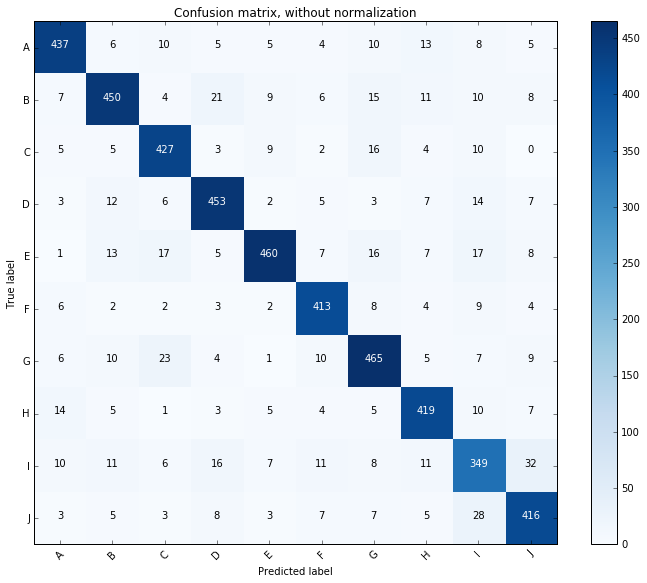

In [20]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix

y_pred = LogRegModel(train_dataset, train_labels, 5000)
y_true = train_labels[:5000]
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)
class_names = ['A','B', 'C','D','E','F','G','H','I','J']

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,8))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')